# Dimensionality Discussion and Reduction on the AI-ready PHIPS Image Classification Dataset

##### This notebook analyzes the dimensions of the "PHIPS_CrystalHabitAI_Dataset.nc" AI-ready dataset and proposes methods to reduce it.

## Current Dimensions of the Dataset

### Image Data:
Consists of greyscale images as 2D arrays (height x width), with a consistent size (1024×1360 pixels).

### Metadata Variables:

- **Habit Type:** Categorical variable for ice crystal type.

- **Temperature:** Continuous variable representing capture temperature.

- **Mean Intensity:** Derived from pixel values.

- **Latitude and Longitude:** Geolocation data.

- **Altitude:** Aircraft altitude during capture.

### Challenges Presented by Current Dimensions

- **High Dimensionality:** Each image contains over a million pixels, complicating machine learning model training.

- **Image Variability:** Diverse ice crystal shapes can lead to varied pixel intensity distributions, affecting classification.

- **Limited Contextual Information:** Missing additional features (e.g. humidity) that could enhance analyses. While relative humidity was computed in the P-3 met data using dewpoint and temperature measurements from probes mounted on the P-3, these measurements were not always relaible.

- **Imbalanced Classes:** Potential overrepresentation of certain habit types can bias model performance.

- **Noise and Background Variability:** Background noise may skew pixel intensity values and affect analyses.

- **Interpretability:** High dimensionality complicates understanding relationships between variables.

In [25]:
# Import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.manifold import TSNE

In [6]:
# Define the file path of the dataset
file_path = '/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

# Display the dataset
ds

<xarray.Dataset>
Dimensions:      (samples: 440, height: 1024, width: 1360)
Coordinates:
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 433 434 435 436 437 438 439
Dimensions without coordinates: height, width
Data variables:
    image_array  (samples, height, width) uint8 ...
    timestamp    (samples) <U19 ...
    label        (samples) <U14 ...
    latitude     (samples) float64 ...
    longitude    (samples) float64 ...
    temperature  (samples) float64 ...
    altitude     (samples) float64 ...
Attributes:
    description:    AI-ready dataset for ice crystal habit classification in ...
    creation_date:  2024-10-24
    author:         Valeria Garcia (vgarcia1@uw.edu)

### 1. Principal Component Analysis (PCA)
##### Captures linear relationships in the data. Helps in reducing dimensionality while preserving variance, useful for initial exploratory data analysis.

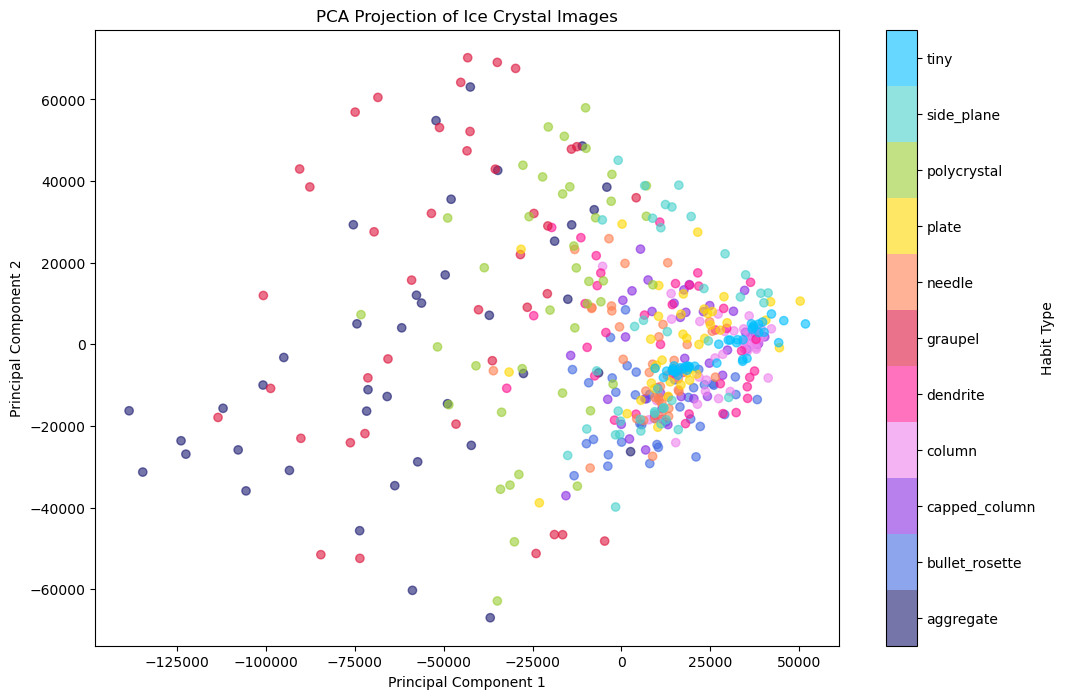

In [24]:
# Define custom colors for the 11 habits
custom_colors = [
    "midnightblue",
    "royalblue",
    "blueviolet",
    "violet",
    "deeppink",
    "crimson",
    "coral",
    "gold",
    "yellowgreen",
    "mediumturquoise",
    "deepskyblue"
]

# Create a custom colormap
cmap = ListedColormap(custom_colors)

# Map habit labels to numerical categories for color mapping
habit_mapping = {habit: i for i, habit in enumerate(np.unique(ds['label'].values))}
habit_colors = np.array([habit_mapping[label] for label in ds['label'].values])

# Flatten the image arrays for PCA
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Perform PCA on the flattened image arrays
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_arrays)

# Set up the boundaries and normalization for the color bar
bounds = np.arange(len(custom_colors) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# Plot the PCA result with the custom colormap
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=habit_colors, cmap=cmap, norm=norm, alpha=0.6)
cbar = plt.colorbar(scatter, ticks=np.arange(len(custom_colors)), label='Habit Type')

# Set habit names as tick labels for the color bar
cbar.ax.set_yticklabels([habit for habit in habit_mapping.keys()])

plt.title('PCA Projection of Ice Crystal Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

##### The cluster of the plate, tiny, column, and capped-columns ice crystal habits suggest that the images from these habits share common features that differentiate them from other habits. The fact that these clusters are centered at positive values on the x-axis (PC1) and values near 0 on the y-axis (PC2) suggests that PC1 explains most of the varies in these clusters. That is, the primary distinguishing features among the ice crystal images are represented along PC1, with high positive values indicating images that significantly differ from the mean along that component.

##### Aggregates and graupel dots look also similarily distributed, suggesting these two habit types share similar features (which is unsurprising given that aggregated particles sometimes exhbit the same clumping/bumpy textures in images as grauepl). 

### 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)
##### Captures non-linear relationships in the data. Good for visualizing high-dimensional data in two or three dimensions and for uncovering clusters in complex datasets

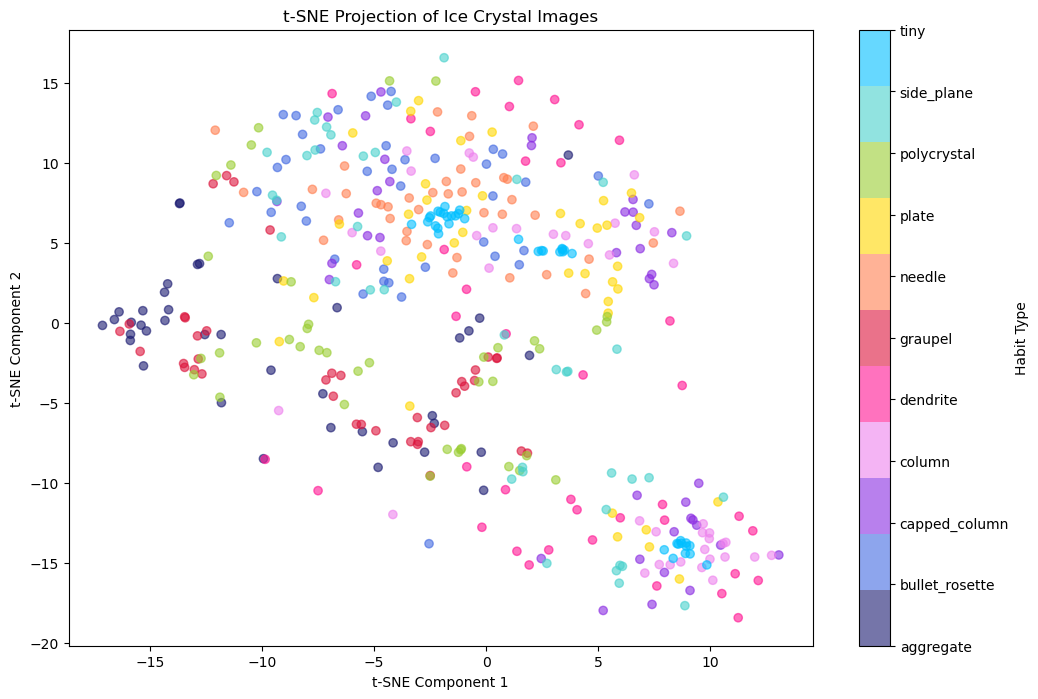

In [26]:
# Preprocess the data
# Flatten the image arrays for t-SNE
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Perform t-SNE on the flattened image arrays
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(image_arrays)

# Plot the t-SNE result with the custom colormap
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=habit_colors, cmap=cmap, alpha=0.6)
cbar = plt.colorbar(scatter, ticks=np.arange(11), label='Habit Type')
cbar.ax.set_yticklabels(habit_mapping.keys())  # Label color bar with habit names
plt.title('t-SNE Projection of Ice Crystal Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()